In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
TRAINING_DATA = 'Train data path'

params = {
    'batch_size' : 32,
    'img_width' : 256,
    'img_height' : 256
}

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train = image_dataset_from_directory(
    TRAINING_DATA,
    labels = 'inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size= params['batch_size'],
    image_size= (params['img_width'], params['img_height']),
    shuffle = True,
    seed = 1997,
    validation_split = 0.2,
    subset='training'
)

Found 217 files belonging to 3 classes.
Using 174 files for training.


In [ ]:
print(train)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
valid = image_dataset_from_directory(
    TRAINING_DATA,
    labels = 'inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size= params['batch_size'],
    image_size= (params['img_width'], params['img_height']),
    shuffle = True,
    seed = 1997,
    validation_split = 0.2,
    subset='validation'
)

Found 217 files belonging to 3 classes.
Using 43 files for validation.


In [ ]:
class_names = train.class_names
print(class_names)

['otherdogs', 'raon', 'winter']


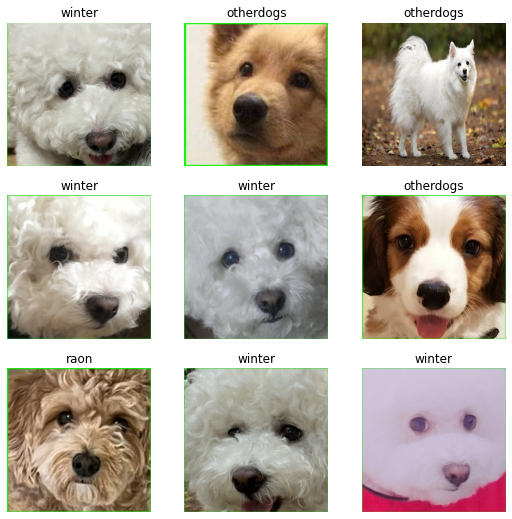

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))
for image, label in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [ ]:
from tensorflow.keras import layers

normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255)

In [ ]:
normed_ds = train.map(lambda x, y : (normalization_layer(x), y))
img_batch, label_batch = next(iter(normed_ds))

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# first model : 3 중첩 conv, pooling layer를 거치고 2중 Dense layer를 거쳐 결과 출력

num_class = 3

model = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(
            1.0 / 255, input_shape=(256, 256, 3)
        ),
        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dense(num_class),
    ]
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)      

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
# Early stop rule 및 checkpoint 지정

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1)

checkpoint = "checkpoint.ckpt"
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

In [ ]:
epochs=50

model.fit(
    train, validation_data=valid, verbose=1, callbacks=[es, mc], epochs=epochs
)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 2.5040 - accuracy: 0.3793
Epoch 1: val_loss improved from inf to 1.11328, saving model to checkpoint.ckpt
6/6 [==============================] - 25s 4s/step - loss: 2.5040 - accuracy: 0.3793 - val_loss: 1.1133 - val_accuracy: 0.1860
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 1.0766 - accuracy: 0.3793
Epoch 2: val_loss improved from 1.11328 to 0.87314, saving model to checkpoint.ckpt
6/6 [==============================] - 15s 2s/step - loss: 1.0766 - accuracy: 0.3793 - val_loss: 0.8731 - val_accuracy: 0.5581
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.9145 - accuracy: 0.4943
Epoch 3: val_loss improved from 0.87314 to 0.76892, saving model to checkpoint.ckpt
6/6 [==============================] - 15s 2s/step - loss: 0.9145 - accuracy: 0.4943 - val_loss: 0.7689 - val_accuracy: 0.8837
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.7471
Epo

In [ ]:
model.evaluate(valid)
# overfitting 발생, test accuracy => 100%, validation accuracy => 88%

2/2 [==============================] - 2s 218ms/step - loss: 0.4417 - accuracy: 0.8837


[0.4416739046573639, 0.8837209343910217]

In [ ]:
sample = 'sample path'

In [ ]:
# Data argumentation으로 train 데이터 수 늘이기

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# data_generator = ImageDataGenerator(rescale = 1./255,
#                                     rotation_range=45.,
#                                     validation_split=0.2)
# train_gen = data_generator.flow_from_directory(
#     TRAINING_DATA,
#     target_size=(params['img_height'], params['img_width']),
#     batch_size= params['batch_size'],
#     class_mode='categorical',
#     subset='training'
# )

# valid_gen = data_generator.flow_from_directory(
#     TRAINING_DATA,
#     target_size=(params['img_height'], params['img_width']),
#     batch_size= params['batch_size'],
#     class_mode='categorical',
#     subset='validation'
# )

Found 175 images belonging to 3 classes.
Found 42 images belonging to 3 classes.


In [ ]:
# model 2 : input을 받은 후에 processing, 출력 Dense로 가기 전 Dropout 기법을 이용해 불필요한 params drop

from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dropout, Dense

num_classes = 3

model = tf.keras.Sequential(
    [
        InputLayer(input_shape=(params['img_width'], params['img_height'], 3)),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
        Conv2D(16, 3, padding="same", activation="relu"),
        MaxPool2D(),
        Conv2D(32, 3, padding="same", activation="relu"),
        MaxPool2D(),
        Conv2D(64, 3, padding="same", activation="relu"),
        MaxPool2D(),
        Conv2D(128, 3, padding="same", activation="relu"),
        MaxPool2D(),
        Conv2D(128, 3, padding="same", activation="relu"),
        MaxPool2D(),
        Flatten(),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dense(6),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
epochs=50

model.fit(
    train, validation_data=valid, verbose=1, callbacks=[es, mc], epochs=epochs
)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 1.4808 - accuracy: 0.3506
Epoch 1: val_loss did not improve from 0.32484
6/6 [==============================] - 17s 2s/step - loss: 1.4808 - accuracy: 0.3506 - val_loss: 1.5094 - val_accuracy: 0.2558
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 1.2205 - accuracy: 0.3391
Epoch 2: val_loss did not improve from 0.32484
6/6 [==============================] - 16s 2s/step - loss: 1.2205 - accuracy: 0.3391 - val_loss: 0.9576 - val_accuracy: 0.5581
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 1.0104 - accuracy: 0.5000
Epoch 3: val_loss did not improve from 0.32484
6/6 [==============================] - 15s 2s/step - loss: 1.0104 - accuracy: 0.5000 - val_loss: 0.7441 - val_accuracy: 0.6977
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.9040 - accuracy: 0.6207
Epoch 4: val_loss did not improve from 0.32484
6/6 [==============================] - 16s 2s/step - loss: 0.90

In [ ]:
model.evaluate(valid)
# overfitting 제거, test accuracy => 95%, validation accuracyt => 88%

2/2 [==============================] - 2s 225ms/step - loss: 0.3216 - accuracy: 0.8837


[0.3216440975666046, 0.8837209343910217]

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img

sample = 'test sample path'
picture = img.imread(sample)
plt.imshow(picture)
plt.show()

sample = tf.keras.preprocessing.image.load_img(
    sample, target_size=(256,256)
)


sample = tf.keras.preprocessing.image.img_to_array(sample)
sample = tf.expand_dims(sample, 0)

pred = model.predict(sample)
score = tf.nn.softmax(pred[0])

print('prediction = {}, confidence = {}'.format(
    class_names[np.argmax(score)], 100*np.max(score)
))

FileNotFoundError: ignored

In [ ]:
# newly test data 생성
test = image_dataset_from_directory(
    '/content/sample_data/train',
    labels = 'inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size= params['batch_size'],
    image_size= (params['img_width'], params['img_height']),
    shuffle = True,
    seed = 1997,
)

Found 8 files belonging to 1 classes.


In [ ]:
model.evaluate(test)
# test accuray : 87.5%

1/1 [==============================] - 1s 526ms/step - loss: 0.1292 - accuracy: 0.8750


[0.129229336977005, 0.875]